# 初期宣言

### Copyright 2022 Google LLC. Double-click for license information.

In [1]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
from huggingface_hub import login
login()

## Null-text inversion + Editing with Prompt-to-Prompt

In [2]:
from typing import Optional, Union, Tuple, List, Callable, Dict
from tqdm.notebook import tqdm
import torch
from diffusers import StableDiffusion3Pipeline, DDIMScheduler
import torch.nn.functional as nnf
import numpy as np
import abc
import shutil
from torch.optim.adam import Adam
from PIL import Image
from diffusers import StableDiffusion3Pipeline, DDIMInverseScheduler, AutoencoderKL, DDIMScheduler
from torchvision import transforms as tfms

In [3]:
from typing import Union, Tuple, Optional

import matplotlib.pyplot as plt
import torch
from PIL import Image
from diffusers import StableDiffusion3Pipeline, DDIMInverseScheduler, AutoencoderKL, DDIMScheduler, StableDiffusionPipeline
from torchvision import transforms as tvt

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float16

In [5]:
import torch

pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", 
                                                torch_dtype=torch.float16
                                                )
# pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",torch_dtype=torch.float16).to(device)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [5]:
# pipe.scheduler.set_timesteps(14)
# timesteps = pipe.scheduler.timesteps
# for t in reversed(timesteps):
#     # Reverse diffusion step
#     latent_model_input = pipe.scheduler.scale_model_input(latents, t)
#     with torch.no_grad():
#         noise_pred = pipe.unet(latent_model_input, t, text_embeddings=pipeline.tokenizer(prompt, return_tensors="pt").input_ids.to(device)).sample

#     latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

AttributeError: 'FlowMatchEulerDiscreteScheduler' object has no attribute 'scale_model_input'

In [6]:
generator = generator=torch.Generator().manual_seed(125)

In [50]:
print(f"Seed: {generator.seed()}")

Seed: 18162818934576940874


  0%|          | 0/28 [00:00<?, ?it/s]

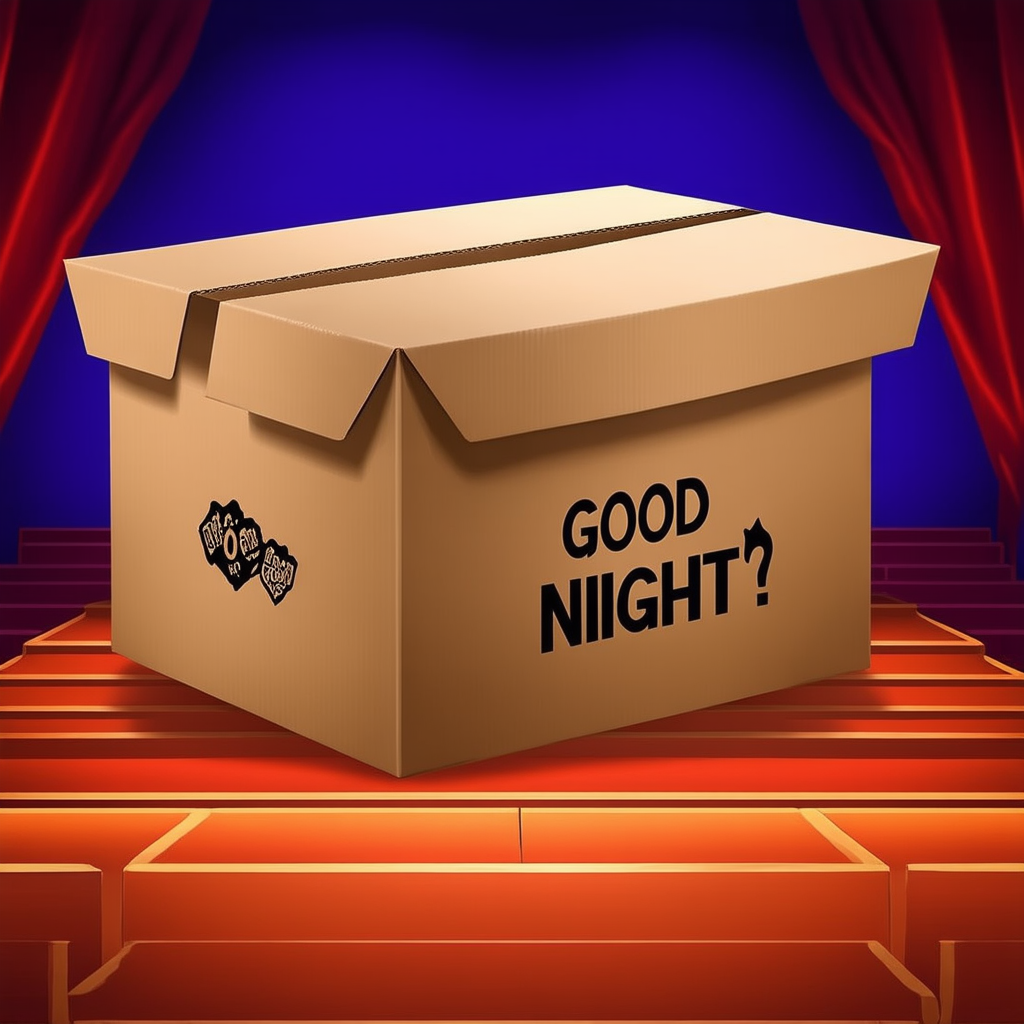

In [9]:
generator = torch.Generator().manual_seed(123)
image = pipe(
    "A cardboard box with the phrase “GOOD NIGHT”, the cardboard box is large and sits on a theater stage.",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
    generator=generator,
).images[0]
image

In [7]:
generator = torch.Generator().manual_seed(125)
image = pipe(
    "A cardboard box with the phrase “”, the cardboard box is large and sits on a theater stage.",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
    generator=generator,
).images[0]
image

KeyboardInterrupt: 

  0%|          | 0/28 [00:00<?, ?it/s]

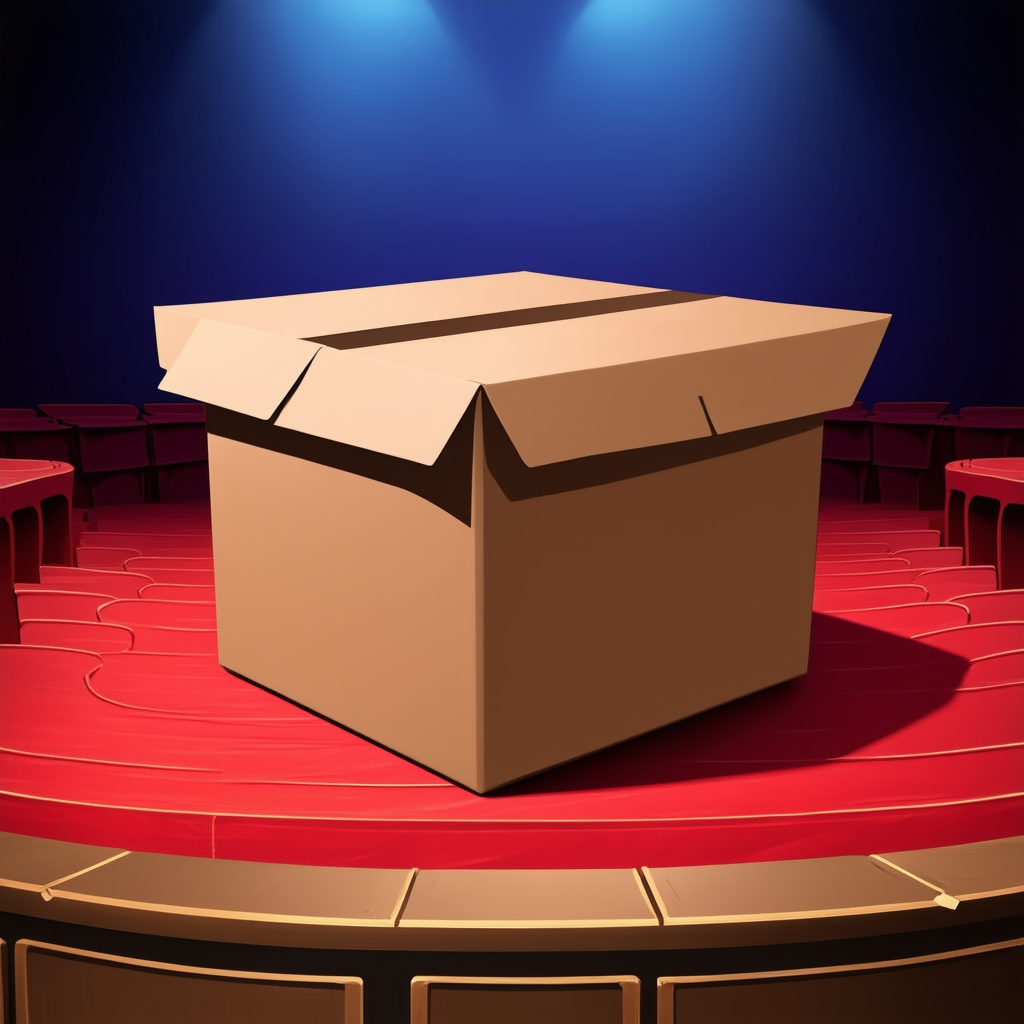

In [111]:
generator = torch.Generator().manual_seed(126)
image = pipe(
    "A cardboard box, the cardboard box is large and sits on a theater stage.",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
    generator=generator,
).images[0]
image

In [5]:
generator = generator=torch.Generator().manual_seed(124)
prompt = "A cardboard box with the phrase “GOOD NIGHT”, the cardboard box is large and sits on a theater stage."
with torch.no_grad():
    latent = pipe(
        prompt,
        negative_prompt="",
        num_inference_steps=28,
        guidance_scale=7.0,
        generator=generator,
        # output_type='latent',
        return_dict=False
    )[0]

  0%|          | 0/28 [00:00<?, ?it/s]

In [6]:
generator = torch.Generator().manual_seed(123)
latents = pipe(
    "A cardboard box with the phrase “GOOD NIGHT”, the cardboard box is large and sits on a theater stage.",
    negative_prompt="",
    num_inference_steps=0,
    guidance_scale=7.0,
    generator=generator,
    output_type='latent'
)[0]
latents

0it [00:00, ?it/s]

tensor([[[[ 0.4219,  1.4268, -1.4160,  ...,  0.6489,  0.0177, -1.1299],
          [ 0.4753,  0.1185, -0.1031,  ..., -0.6611, -0.8594,  0.7178],
          [ 1.0527,  0.4636, -1.8242,  ...,  1.1562, -1.7031, -1.8516],
          ...,
          [ 0.1505,  0.4414,  2.0879,  ...,  0.4126, -3.3613, -0.7705],
          [-0.9756, -1.5498,  0.9072,  ..., -0.6558,  1.1904,  1.1865],
          [-1.7812, -0.1654,  1.1660,  ...,  0.0704, -2.0312, -0.5576]],

         [[-1.4619, -1.7021,  1.4697,  ..., -0.5332, -0.1245, -0.6055],
          [-0.1304, -0.4373,  1.3828,  ..., -0.5449,  0.4421, -1.5078],
          [-0.8550, -0.9951,  1.1221,  ..., -2.2266, -1.1016,  1.8096],
          ...,
          [ 0.4202, -1.8506,  1.2969,  ...,  1.1191, -0.3684, -0.5488],
          [-0.2937,  0.5786, -0.1415,  ..., -1.5693,  0.7173, -0.3513],
          [-0.6084,  0.6504,  0.4839,  ..., -1.4521, -0.1429, -0.9136]],

         [[ 0.0736, -2.3086,  1.3574,  ..., -1.0273, -0.8760, -1.2051],
          [ 1.0410,  1.1260,  

In [7]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = pipe.vae

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
t5_text_encoder = pipe.text_encoder_3
t5_tokenizer = pipe.tokenizer_3

# 3. 
transformer = pipe.transformer
scheduler = pipe.scheduler

In [8]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
transformer.to(torch_device)

SD3Transformer2DModel(
  (pos_embed): PatchEmbed(
    (proj): Conv2d(16, 1536, kernel_size=(2, 2), stride=(2, 2))
  )
  (time_text_embed): CombinedTimestepTextProjEmbeddings(
    (time_proj): Timesteps()
    (timestep_embedder): TimestepEmbedding(
      (linear_1): Linear(in_features=256, out_features=1536, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=1536, out_features=1536, bias=True)
    )
    (text_embedder): PixArtAlphaTextProjection(
      (linear_1): Linear(in_features=2048, out_features=1536, bias=True)
      (act_1): SiLU()
      (linear_2): Linear(in_features=1536, out_features=1536, bias=True)
    )
  )
  (context_embedder): Linear(in_features=4096, out_features=1536, bias=True)
  (transformer_blocks): ModuleList(
    (0-22): 23 x JointTransformerBlock(
      (norm1): AdaLayerNormZero(
        (silu): SiLU()
        (linear): Linear(in_features=1536, out_features=9216, bias=True)
        (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=False)
 

In [26]:
prompt = ["a photograph of an astronaut riding a horse"]
prompt_2 = prompt
prompt_3 = prompt

height = 1024                        # default height of Stable Diffusion
width = 1024                         # default width of Stable Diffusion

num_inference_steps = 28           # Number of denoising steps

guidance_scale = 7.0                # Scale for classifier-free guidance

generator = torch.manual_seed(123)    # Seed generator to create the inital latent noise

batch_size = len(prompt)

num_images_per_prompt = 1

In [32]:
prompt_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
prompt_embed = text_encoder(prompt_input.input_ids.to(torch_device))
pooled_prompt_embed = prompt_embed[0]
_, seq_len, _ = prompt_embed.shape
# duplicate text embeddings for each generation per prompt, using mps friendly method
prompt_embed = prompt_embed.repeat(1, num_images_per_prompt, 1)
prompt_embed = prompt_embed.view(batch_size * num_images_per_prompt, seq_len, -1)
pooled_prompt_embeds = pooled_prompt_embed.repeat(1, num_images_per_prompt, 1)
pooled_prompt_embeds = pooled_prompt_embed.view(batch_size * num_images_per_prompt, -1)

prompt_2_input = tokenizer(prompt_2, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
prompt_2_embed = text_encoder(prompt_2_input.input_ids.to(torch_device))[0]
pooled_prompt_2_embed = prompt_2_embed[0]
_, seq_len, _ = prompt_2_embed.shape
# duplicate text embeddings for each generation per prompt, using mps friendly method
prompt_2_embed = prompt_2_embed.repeat(1, num_images_per_prompt, 1)
prompt_2_embed = prompt_2_embed.view(batch_size * num_images_per_prompt, seq_len, -1)
pooled_prompt_2_embeds = pooled_prompt_2_embed.repeat(1, num_images_per_prompt, 1)
pooled_prompt_2_embeds = pooled_prompt_2_embed.view(batch_size * num_images_per_prompt, -1)

clip_prompt_embeds = torch.cat([prompt_embed, prompt_2_embed], dim=-1)

t5_prompt_input = t5_tokenizer(prompt_3, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
t5_prompt_embed = t5_text_encoder(t5_prompt_input.input_ids.to(torch_device))[0]

clip_prompt_embeds = torch.nn.functional.pad(
                clip_prompt_embeds, (0, t5_prompt_embed.shape[-1] - clip_prompt_embeds.shape[-1])
            )

prompt_embeds = torch.cat([clip_prompt_embeds, t5_prompt_embed], dim=-2)
pooled_prompt_embeds = torch.cat([pooled_prompt_embed, pooled_prompt_2_embed], dim=-1)


AttributeError: 'CLIPTextModelOutput' object has no attribute 'shape'

In [34]:
max_length = prompt_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)
uncond_embeds = text_encoder(uncond_input.input_ids.to(torch_device))[0]

uncond_2_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)
uncond_2_embeds = text_encoder(uncond_input.input_ids.to(torch_device))[0]

t5_prompt_input = tokenizer([""] * batch_size, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
t5_prompt_embed = text_encoder(prompt_2_input.input_ids.to(torch_device))[0]

In [22]:
prompt_embeds = torch.cat([uncond_embedds, text_embeds])

In [23]:
latents = latent
latents = latents.to(torch_device)

In [24]:
scheduler.set_timesteps(num_inference_steps)

In [25]:
# do_classifier_free_guidance = pipe.do_classifier_free_guidance
joint_attention_kwargs = pipe.joint_attention_kwargs

In [26]:
prompt_embeds = prompt_embeds.to(device)
pooled_prompt_embeds = pooled_prompt_embeds.to(device)

In [58]:
for i, t in enumerate(scheduler.timesteps):
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2)
    # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
    timestep = t.expand(latent_model_input.shape[0])

    noise_pred = transformer(
        hidden_states=latent_model_input.to(device),
        timestep=timestep.to(device),
        encoder_hidden_states=prompt_embeds.to(device),
        pooled_projections=pooled_prompt_embeds.to(device),
        # joint_attention_kwargs=joint_attention_kwargs,
        return_dict=False,
    )[0]

    # perform guidance
    # if do_classifier_free_guidance:
    #     noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    #     noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents_dtype = latents.dtype
    latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0]

    if latents.dtype != latents_dtype:
        if torch.backends.mps.is_available():
            # some platforms (eg. apple mps) misbehave due to a pytorch bug: https://github.com/pytorch/pytorch/pull/99272
            latents = latents.to(latents_dtype)

    # if callback_on_step_end is not None:
    #     callback_kwargs = {}
    #     for k in callback_on_step_end_tensor_inputs:
    #         callback_kwargs[k] = locals()[k]
    #     callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)

    #     latents = callback_outputs.pop("latents", latents)
    #     prompt_embeds = callback_outputs.pop("prompt_embeds", prompt_embeds)
    #     negative_prompt_embeds = callback_outputs.pop("negative_prompt_embeds", negative_prompt_embeds)
    #     negative_pooled_prompt_embeds = callback_outputs.pop(
    #         "negative_pooled_prompt_embeds", negative_pooled_prompt_embeds
    #     )

    # call the callback, if provided
    # if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
    #     progress_bar.update()

    # if XLA_AVAILABLE:
    #     xm.mark_step()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x768 and 2048x1536)

In [53]:
print(len(prompt_embeds[0]))
print(len(uncond_embeddings[0]))
print(len(pooled_prompt_embeds))
latent_model_input[0].shape

768
768
768


torch.Size([16, 128, 128])

# 境目

  0%|          | 0/28 [00:00<?, ?it/s]

Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT b

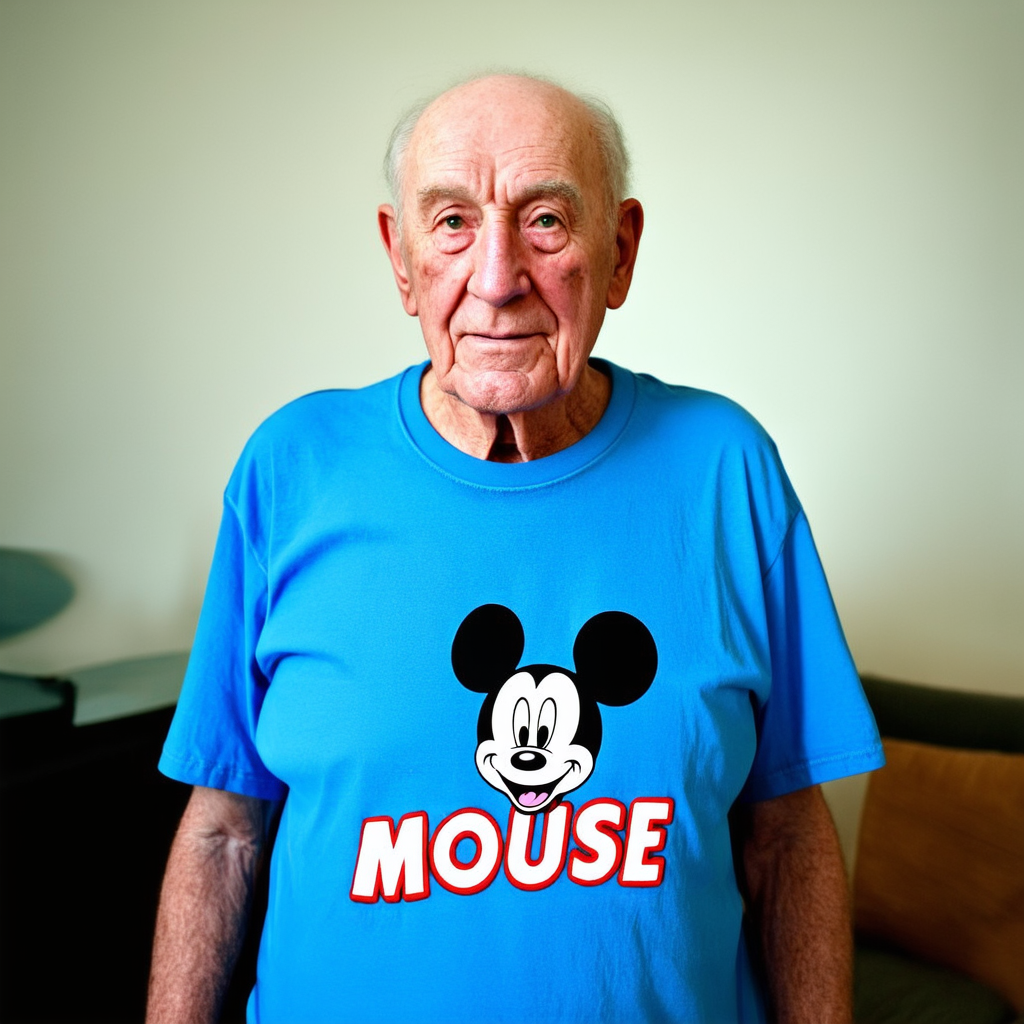

In [16]:
image = pipe(
    "An old man wearing a T-shirt that says 'MOUSE'.",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
).images[0]
image

  0%|          | 0/28 [00:00<?, ?it/s]

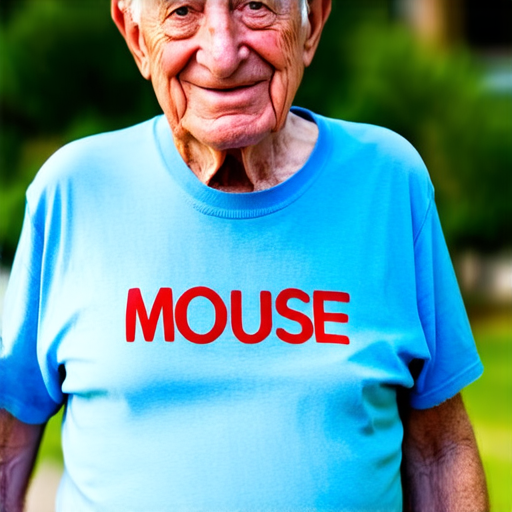

In [8]:
image = pipe(
    "An old man wearing a T-shirt that says 'MOUSE'.",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
    width=512,
    height=512
).images[0]
image

  0%|          | 0/28 [00:00<?, ?it/s]

Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT b

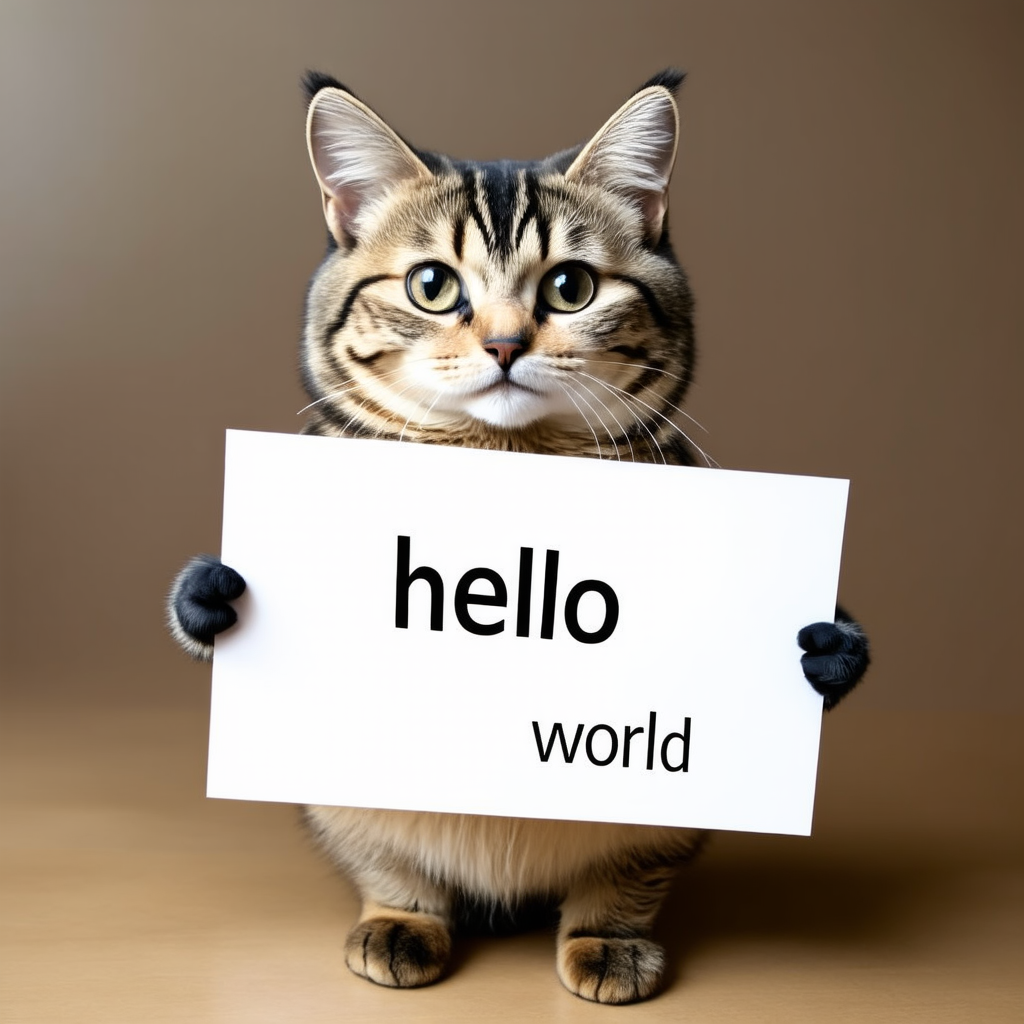

In [22]:
image = pipe(
    "A cat holding a sign that says hello world",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
).images[0]
image

  0%|          | 0/28 [00:00<?, ?it/s]

Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT backend is ineffective.
Passing `scale` via `joint_attention_kwargs` when not using the PEFT b

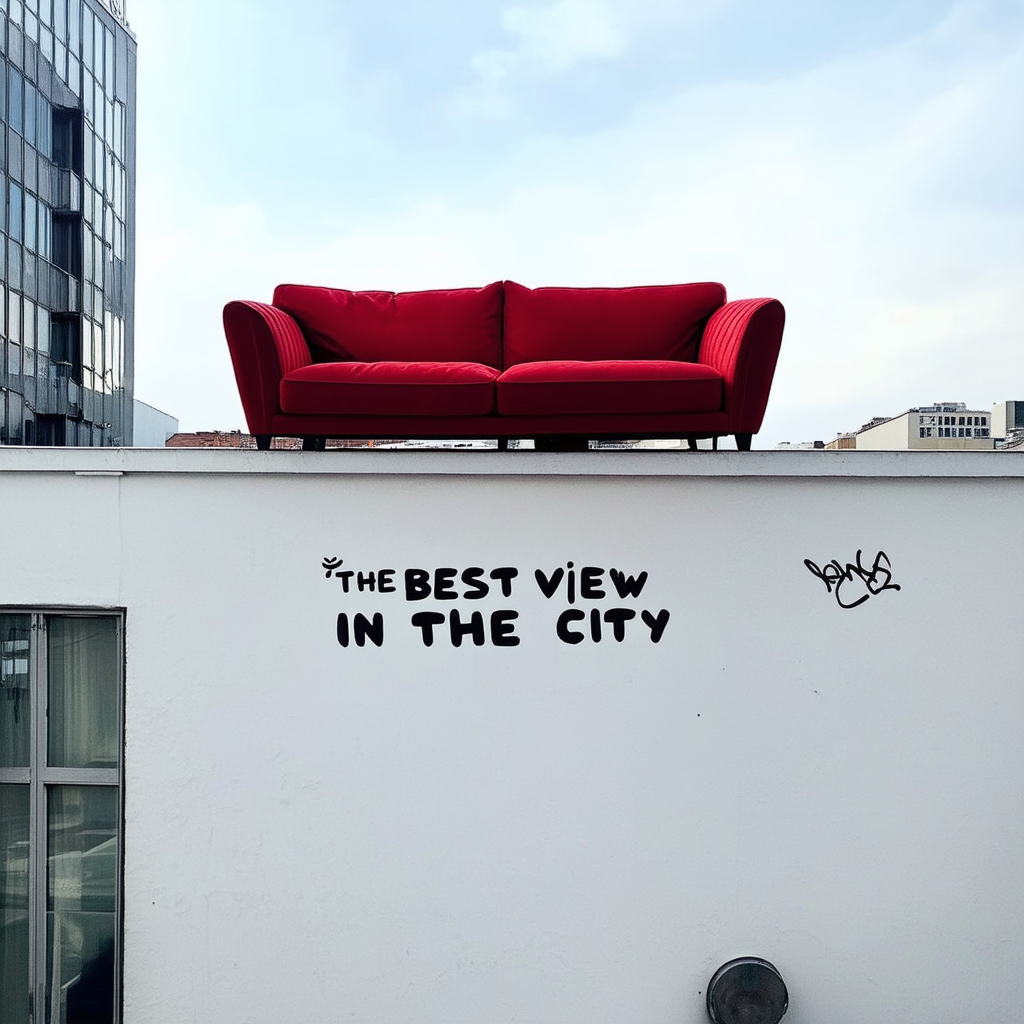

In [20]:
image = pipe(
    "A red sofa on top of a white building. Graffiti with the text “the best view in the city”.",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
).images[0]
image

For loading the Stable Diffusion using Diffusers, follow the instuctions https://huggingface.co/blog/stable_diffusion and update MY_TOKEN with your token.